#  Relax Inc. Take-Home Challenge 
## August Perez

Springboard Data Science track unit 37.2

In [1]:
#imports

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import datetime as dt
from scipy.stats import chi2_contingency


import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose


from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler


#
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
    #reminder code so I can ignore warnings for single code cells:
    # warnings.filterwarnings('ignore')
    # warnings.resetwarnings()

In [2]:
# Load the data
df_user = pd.read_csv('takehome_users.csv', encoding='ISO-8859-1')
df_engage = pd.read_csv('takehome_user_engagement.csv')

In [3]:
print("User Data:")
df_user.head()

User Data:


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [5]:
df_user.describe(include='all')

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,12000,12000,12000,12000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
unique,NaN,11996,11355,11980,5,NaN,NaN,NaN,NaN,NaN
top,NaN,2014-02-11 17:57:53,Araujo Gabriela,AlfieLane@yahoo.com,ORG_INVITE,NaN,NaN,NaN,NaN,NaN
freq,NaN,2,5,2,4254,NaN,NaN,NaN,NaN,NaN
mean,6000.50000,NaN,NaN,NaN,NaN,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,NaN,NaN,NaN,NaN,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,NaN,NaN,NaN,NaN,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,NaN,NaN,NaN,NaN,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,NaN,NaN,NaN,NaN,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,NaN,NaN,NaN,NaN,1.398443e+09,0.000000,0.000000,238.250000,8817.000000


___

In [6]:
print("\nEngagement Data:")
df_engage.head()


Engagement Data:


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [7]:
df_engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [8]:
df_engage.describe(include='all')

,time_stamp,user_id,visited
count,207917,207917.000000,207917.0
unique,207220,NaN,NaN
top,2013-04-06 21:21:37,NaN,NaN
freq,2,NaN,NaN
mean,NaN,5913.314197,1.0
std,NaN,3394.941674,0.0
min,NaN,1.000000,1.0
25%,NaN,3087.000000,1.0
50%,NaN,5682.000000,1.0
75%,NaN,8944.000000,1.0


___
Change col names

edits for clarity, consistency, & succinctness (helps with reducing plot axis label overlap)

In [9]:
df_user.rename(columns={'object_id' : 'user_id', 'last_session_creation_time' : 'last_login', 'opted_in_to_mailing_list' : 'mailing_list', 'enabled_for_marketing_drip' : 'marketing_drip'}, inplace=True)
df_user.head(2)

,user_id,creation_time,name,email,creation_source,last_login,mailing_list,marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0


___

# Missing Data

In [10]:
print("\nMissing Values in User Data:")
print(df_user.isnull().sum())
print("\nMissing Values in Engagement Data:")
print(df_engage.isnull().sum())


Missing Values in User Data:
user_id                  0
creation_time            0
name                     0
email                    0
creation_source          0
last_login            3177
mailing_list             0
marketing_drip           0
org_id                   0
invited_by_user_id    5583
dtype: int64

Missing Values in Engagement Data:
time_stamp    0
user_id       0
visited       0
dtype: int64


In [11]:
missing_last_session_rows = df_user[df_user['last_login'].isnull()]

missing_last_session_rows

,user_id,creation_time,name,email,creation_source,last_login,mailing_list,marketing_drip,org_id,invited_by_user_id
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN
11,12,2014-04-17 23:48:38,Mathiesen Lærke,LaerkeLMathiesen@cuvox.de,ORG_INVITE,NaN,0,0,130,9270.0
14,15,2013-07-16 21:33:54,Theiss Ralf,RalfTheiss@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,175,NaN
15,16,2013-02-11 10:09:50,Engel René,ReneEngel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,211,NaN
...,...,...,...,...,...,...,...,...,...,...
11975,11976,2013-12-25 22:01:41,Kohl Leah,LeahKohl@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,248,NaN
11977,11978,2014-04-23 16:28:06,Castro Pedro,PedroCunhaCastro@gustr.com,PERSONAL_PROJECTS,NaN,1,0,29,NaN
11984,11985,2013-07-08 17:23:26,Jespersen Marcus,MarcusTJespersen@cuvox.de,PERSONAL_PROJECTS,NaN,0,0,74,NaN
11992,11993,2013-03-28 23:24:21,Townsend Isabel,IsabelTownsend@cuvox.de,PERSONAL_PROJECTS,NaN,0,0,281,NaN


In [12]:
missing_invited_by_user_rows = df_user[df_user['invited_by_user_id'].isnull()]

missing_invited_by_user_rows

,user_id,creation_time,name,email,creation_source,last_login,mailing_list,marketing_drip,org_id,invited_by_user_id
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN
10,11,2013-12-26 03:55:54,Paulsen Malthe,MaltheAPaulsen@gustr.com,SIGNUP,1.388117e+09,0,0,69,NaN
13,14,2012-10-11 16:14:33,Rivera Bret,BretKRivera@gmail.com,SIGNUP,1.350058e+09,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...
11992,11993,2013-03-28 23:24:21,Townsend Isabel,IsabelTownsend@cuvox.de,PERSONAL_PROJECTS,NaN,0,0,281,NaN
11994,11995,2013-10-21 13:33:17,Werfel Sebastian,SebastianWerfel@gmail.com,PERSONAL_PROJECTS,1.382449e+09,0,0,0,NaN
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN


Look into df_engage to see if last_login for df_user can be filled in

In [13]:
df_engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [14]:
#Looking at top 10 users by count of total logins
    #doesn't exactly apply to problem}
df_engage[['user_id', 'visited']].groupby(by='user_id').sum().sort_values(by='visited', ascending=False).head(10)

,visited
user_id,
3623,606
906,600
1811,593
7590,590
8068,585
9402,581
4022,580
3269,566
9312,547


In [15]:
max_login = df_engage[['user_id', 'time_stamp']].groupby(by='user_id').max()

print('count of users who have ever logged in:\n', len(max_login))
print('count of total users:\n', len(df_user))
print('count of users who have NEVER logged in:\n', len(df_user) - len(max_login))

max_login.head()

count of users who have ever logged in:
 8823
count of total users:
 12000
count of users who have NEVER logged in:
 3177


,time_stamp
user_id,
1,2014-04-22 03:53:30
2,2014-03-31 03:45:04
3,2013-03-19 23:14:52
4,2013-05-22 08:09:28
5,2013-01-22 10:14:20


Users that have never logged in match null count for 'last_login' in df_user.

Plan on imputing pd.NaT to indicate no login (& work nicer when converting to datetime)

___
impute pd.NaT for 'last_login' col

This still is a null but on purpose

In [16]:
df_user['last_login'] = df_user['last_login'].fillna(pd.NaT)

In [17]:
df_user['last_login'].value_counts(dropna=False).head()

last_login
NaT             3177
1401868018.0       2
1401916897.0       2
1398138810.0       1
1381811721.0       1
Name: count, dtype: int64

___
impute invited_by_user_id with 0 to indicate no invitation

In [18]:
df_user['invited_by_user_id'] = df_user['invited_by_user_id'].fillna(0)

In [19]:
df_user['invited_by_user_id'].value_counts(dropna=False).head()

invited_by_user_id
0.0        5583
10741.0      13
2527.0       12
1525.0       11
2308.0       11
Name: count, dtype: int64

In [20]:
df_user.isnull().sum()

user_id                  0
creation_time            0
name                     0
email                    0
creation_source          0
last_login            3177
mailing_list             0
marketing_drip           0
org_id                   0
invited_by_user_id       0
dtype: int64

# Check data types

In [21]:
print('df_engage:\n')
print(df_engage.dtypes)
df_engage.head(2)

df_engage:

time_stamp    object
user_id        int64
visited        int64
dtype: object


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1


In [22]:
print('df_user:\n')
print(df_user.dtypes)
df_user.head(2)

df_user:

user_id                 int64
creation_time          object
name                   object
email                  object
creation_source        object
last_login             object
mailing_list            int64
marketing_drip          int64
org_id                  int64
invited_by_user_id    float64
dtype: object


,user_id,creation_time,name,email,creation_source,last_login,mailing_list,marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1398138810.0,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1396237504.0,0,0,1,316.0


In [23]:
#datetime

df_engage['time_stamp'] = pd.to_datetime(df_engage['time_stamp'])

df_user['creation_time'] = pd.to_datetime(df_user['creation_time'])

    #converting from UNIX timestamp
df_user['last_login'] = pd.to_datetime(df_user['last_login'], unit='s')

In [24]:
print(df_engage.dtypes)
print()
print(df_user.dtypes)

time_stamp    datetime64[ns]
user_id                int64
visited                int64
dtype: object

user_id                        int64
creation_time         datetime64[ns]
name                          object
email                         object
creation_source               object
last_login            datetime64[ns]
mailing_list                   int64
marketing_drip                 int64
org_id                         int64
invited_by_user_id           float64
dtype: object


# Create 'adopted' column
    "a user who has logged into the product on three separate days in at least one sevenday period"

In [25]:
def is_adopted_user(logins):
    logins.sort()  # Sort the list of login dates
    for i in range(len(logins) - 2):
        if logins[i + 2] <= logins[i] + dt.timedelta(days=7):
            return 1
    return 0

In [26]:
user_logins = df_engage.groupby('user_id')['time_stamp'].apply(list)
adopted_user_status = user_logins.apply(is_adopted_user)

adopted_user_status = adopted_user_status.reset_index()
adopted_user_status.columns = ['user_id', 'adopted_user']

df_user = df_user.merge(adopted_user_status, on='user_id', how='left')
df_user['adopted_user'] = df_user['adopted_user'].fillna(0).astype(int)

In [27]:
df_user.head(20)

,user_id,creation_time,name,email,creation_source,last_login,mailing_list,marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,2013-12-19 03:37:06,0,0,197,11241.0,0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,0.0,0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,74,0.0,0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,302,0.0,0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,2014-06-03 22:08:03,1,1,318,4143.0,1


# Create Features that might help predict user adoption

    ex. total logins, number of distinct login days

In [28]:
# Total logins
total_logins = df_engage.groupby('user_id')['visited'].sum().reset_index()
total_logins.columns = ['user_id', 'total_logins']

In [29]:
# Number of distinct login days
distinct_login_days = df_engage.groupby('user_id')['time_stamp'].nunique().reset_index()
distinct_login_days.columns = ['user_id', 'distinct_login_days']

In [30]:
# Merge features into df_user
df_user = df_user.merge(total_logins, on='user_id', how='left')
df_user = df_user.merge(distinct_login_days, on='user_id', how='left')
df_user['total_logins'] = df_user['total_logins'].fillna(0)
df_user['distinct_login_days'] = df_user['distinct_login_days'].fillna(0)

In [31]:
df_user.head()

,user_id,creation_time,name,email,creation_source,last_login,mailing_list,marketing_drip,org_id,invited_by_user_id,adopted_user,total_logins,distinct_login_days
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,1.0,1.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,14.0,14.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,1.0,1.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,1.0,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,1.0,1.0


# EDA

In [32]:
cols_num = ['total_logins', 'distinct_login_days']
cols_cat = ['creation_source', 'mailing_list', 'marketing_drip', 'adopted_user', ]
cols_time = ['creation_time', 'last_login', ]

    #for cols that have too many unique vals to be considered categorical & aren't actually numerical
cols_info = ['user_id', 'name', 'email', 'org_id', 'invited_by_user_id', ]

In [33]:
df_user.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
user_id,12000.0,NaN,NaN,NaN,6000.5,1.0,3000.75,6000.5,9000.25,12000.0,3464.24595
creation_time,12000,NaN,NaN,NaN,2013-07-16 13:25:32.964499968,2012-05-31 00:43:27,2013-01-15 21:28:22.750000128,2013-08-05 21:35:19.500000,2014-01-28 10:20:12.249999872,2014-05-30 23:59:19,NaN
name,12000,11355,Araujo Gabriela,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
email,12000,11980,AlfieLane@yahoo.com,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
creation_source,12000,5,ORG_INVITE,4254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last_login,8823,NaN,NaN,NaN,2013-09-15 21:08:25.700441856,2012-05-31 08:20:06,2013-03-13 17:16:05,2013-10-27 15:41:10,2014-04-25 16:16:44,2014-06-06 14:58:50,NaN
mailing_list,12000.0,NaN,NaN,NaN,0.2495,0.0,0.0,0.0,0.0,1.0,0.432742
marketing_drip,12000.0,NaN,NaN,NaN,0.149333,0.0,0.0,0.0,0.0,1.0,0.356432
org_id,12000.0,NaN,NaN,NaN,141.884583,0.0,29.0,108.0,238.25,416.0,124.056723
invited_by_user_id,12000.0,NaN,NaN,NaN,3188.691333,0.0,0.0,875.0,6317.0,11999.0,3869.027693


In [34]:
df_user.dtypes

user_id                         int64
creation_time          datetime64[ns]
name                           object
email                          object
creation_source                object
last_login             datetime64[ns]
mailing_list                    int64
marketing_drip                  int64
org_id                          int64
invited_by_user_id            float64
adopted_user                    int32
total_logins                  float64
distinct_login_days           float64
dtype: object

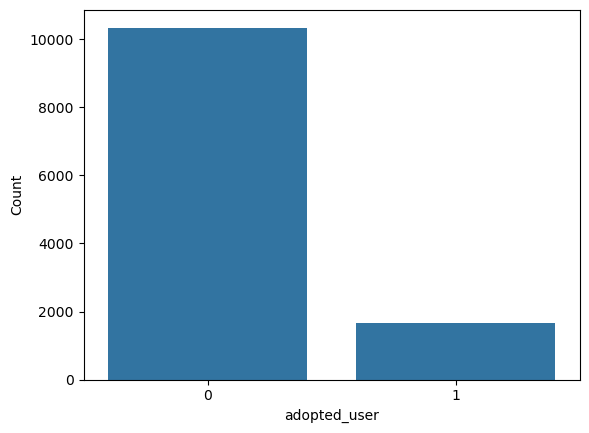

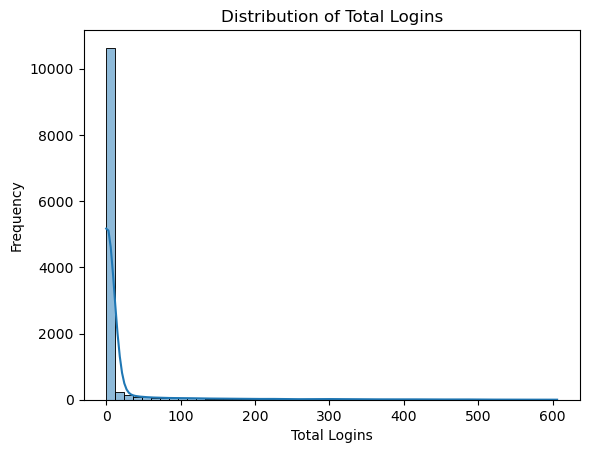

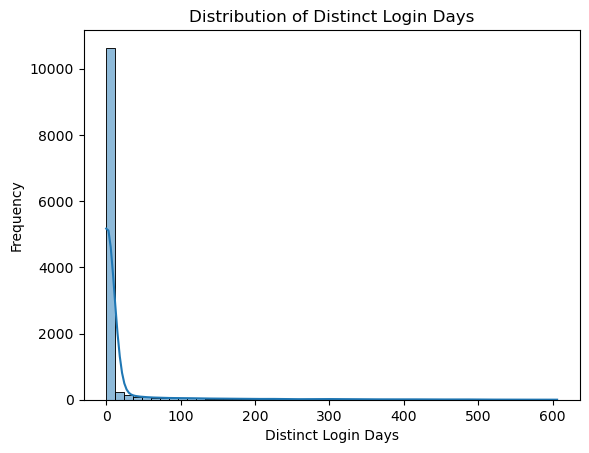

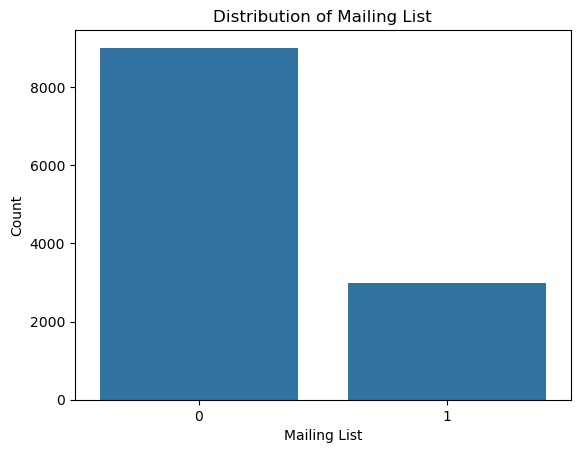

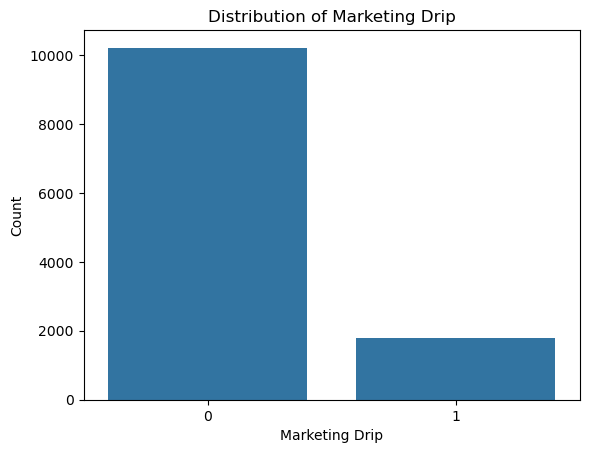

In [35]:
# Adopted & non-adopted
sns.countplot(data=df_user, x='adopted_user')
plt.xlabel('adopted_user')
plt.ylabel('Count')
plt.show()

# Distribution of total logins
sns.histplot(df_user['total_logins'], bins=50, kde=True)
plt.title('Distribution of Total Logins')
plt.xlabel('Total Logins')
plt.ylabel('Frequency')
plt.show()

# Distribution of distinct login days
sns.histplot(df_user['distinct_login_days'], bins=50, kde=True)
plt.title('Distribution of Distinct Login Days')
plt.xlabel('Distinct Login Days')
plt.ylabel('Frequency')
plt.show()

# Distribution of mailing_list
sns.countplot(data=df_user, x='mailing_list')
plt.title('Distribution of Mailing List')
plt.xlabel('Mailing List')
plt.ylabel('Count')
plt.show()

# Distribution of marketing_drip
sns.countplot(data=df_user, x='marketing_drip')
plt.title('Distribution of Marketing Drip')
plt.xlabel('Marketing Drip')
plt.ylabel('Count')
plt.show()

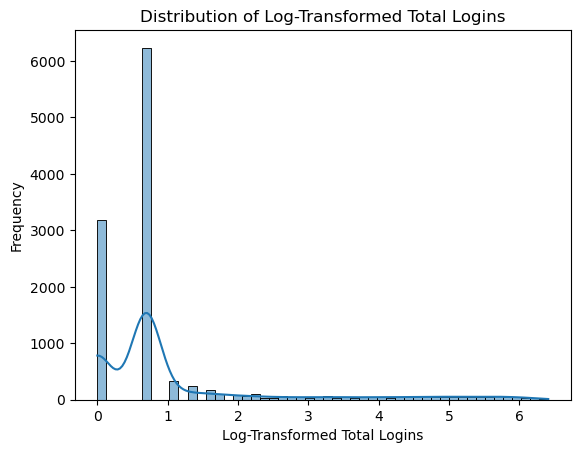

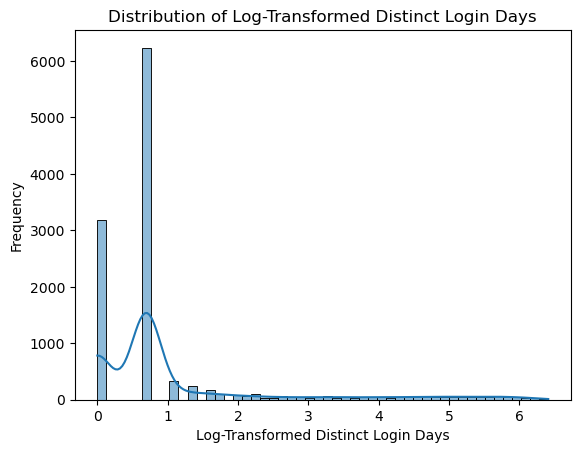

In [36]:
#log transformed for num features (closer look at less frequent values)

# Plotting the log-transformed total logins
sns.histplot(np.log1p(df_user['total_logins']), bins=50, kde=True)
plt.title('Distribution of Log-Transformed Total Logins')
plt.xlabel('Log-Transformed Total Logins')
plt.ylabel('Frequency')
plt.show()

# Plotting the log-transformed distinct login days
sns.histplot(np.log1p(df_user['distinct_login_days']), bins=50, kde=True)
plt.title('Distribution of Log-Transformed Distinct Login Days')
plt.xlabel('Log-Transformed Distinct Login Days')
plt.ylabel('Frequency')
plt.show()

In [37]:
df_user.dtypes

user_id                         int64
creation_time          datetime64[ns]
name                           object
email                          object
creation_source                object
last_login             datetime64[ns]
mailing_list                    int64
marketing_drip                  int64
org_id                          int64
invited_by_user_id            float64
adopted_user                    int32
total_logins                  float64
distinct_login_days           float64
dtype: object

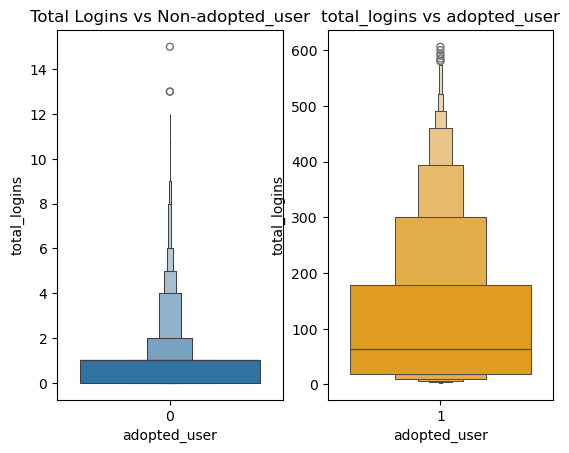

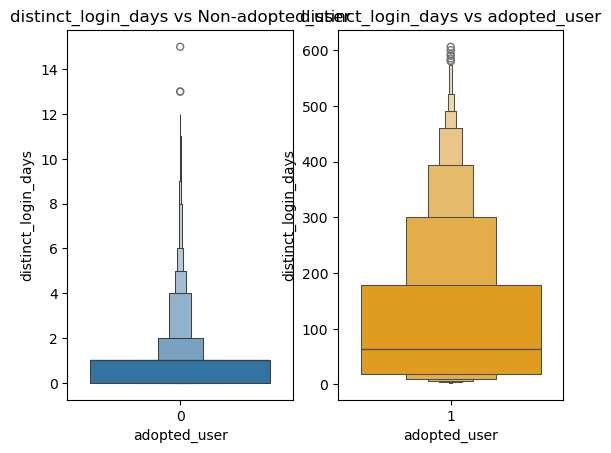

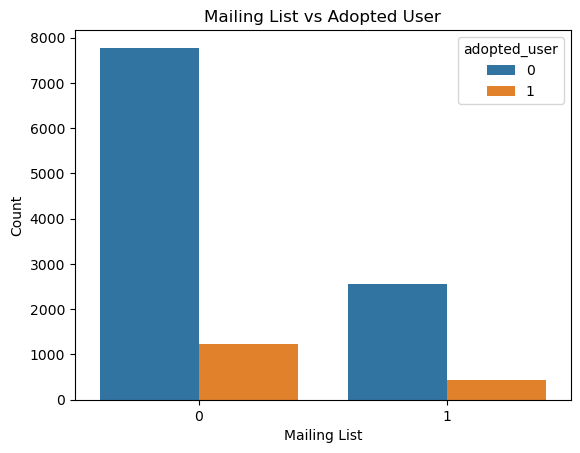

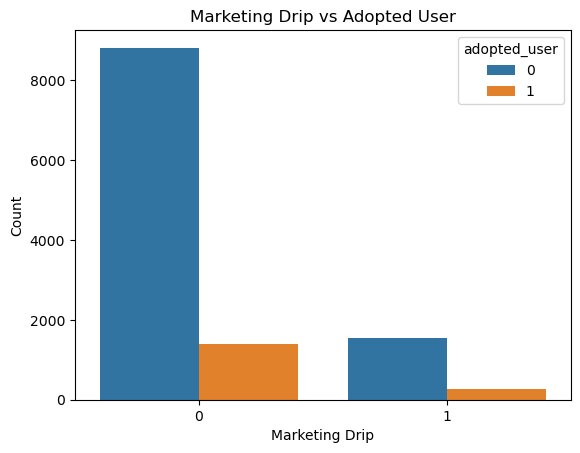

In [38]:
# Relationship between total_logins and adopted_user
fig, axs = plt.subplots(nrows=1, ncols=2)

sns.boxenplot(x='adopted_user', y='total_logins', data=df_user[df_user['adopted_user']==0], ax=axs[0])
axs[0].set_title('Total Logins vs Non-adopted_user')
sns.boxenplot(x='adopted_user', y='total_logins', data=df_user[df_user['adopted_user']==1], color='orange', ax=axs[1])
axs[1].set_title('total_logins vs adopted_user')
plt.show()

# Relationship between distinct_login_days and adopted_user
fig, axs = plt.subplots(nrows=1, ncols=2)

sns.boxenplot(x='adopted_user', y='distinct_login_days', data=df_user[df_user['adopted_user']==0], ax=axs[0])
axs[0].set_title('distinct_login_days vs Non-adopted_user')
sns.boxenplot(x='adopted_user', y='distinct_login_days', data=df_user[df_user['adopted_user']==1], color='orange', ax=axs[1])
axs[1].set_title('distinct_login_days vs adopted_user')
plt.show()

# Relationship between mailing_list and adopted_user
sns.countplot(x='mailing_list', hue='adopted_user', data=df_user)
plt.title('Mailing List vs Adopted User')
plt.xlabel('Mailing List')
plt.ylabel('Count')
plt.show()

# Relationship between marketing_drip and adopted_user
sns.countplot(x='marketing_drip', hue='adopted_user', data=df_user)
plt.title('Marketing Drip vs Adopted User')
plt.xlabel('Marketing Drip')
plt.ylabel('Count')
plt.show()

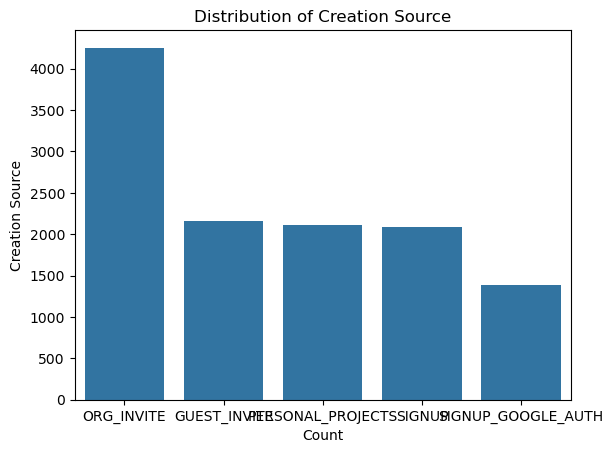

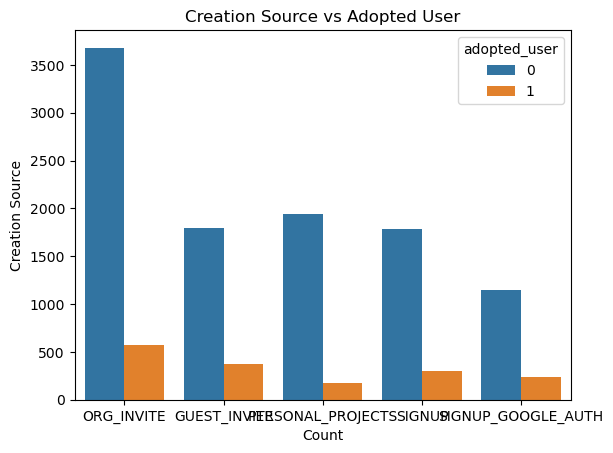

In [39]:
# Distribution of creation_source
sns.countplot(x='creation_source', data=df_user, order=df_user['creation_source'].value_counts().index)
plt.title('Distribution of Creation Source')
plt.xlabel('Count')
plt.ylabel('Creation Source')
plt.show()

# Relationship between creation_source and adopted_user
sns.countplot(x='creation_source', hue='adopted_user', data=df_user, order=df_user['creation_source'].value_counts().index)
plt.title('Creation Source vs Adopted User')
plt.xlabel('Count')
plt.ylabel('Creation Source')
plt.show()

# Observations Thus far

- Adopted users have vastly higher total logins & distinct_login_days
- mailing  list signup & marketing drip subscription don't seem to have a visual effect on user adoption
- org & guest invites look to have the largest effect on user adoption

# Modeling

In [40]:
df_user.head(2)

,user_id,creation_time,name,email,creation_source,last_login,mailing_list,marketing_drip,org_id,invited_by_user_id,adopted_user,total_logins,distinct_login_days
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,1.0,1.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,14.0,14.0


In [41]:
features = df_user.drop(columns=['user_id', 'adopted_user', 'creation_time', 'name', 'email', 'last_login'])
X = pd.get_dummies(features, columns=['creation_source'], drop_first=True)
y = df_user['adopted_user']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [42]:
rf_model = RandomForestClassifier(random_state=9, n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=9)

In [43]:
y_pred = rf_model.predict(X_test)

In [44]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:\n", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      2055
           1       0.93      0.91      0.92       345

    accuracy                           0.98      2400
   macro avg       0.96      0.95      0.95      2400
weighted avg       0.98      0.98      0.98      2400

Confusion Matrix:
 [[2032   23]
 [  30  315]]
Accuracy Score:
 0.9779166666666667


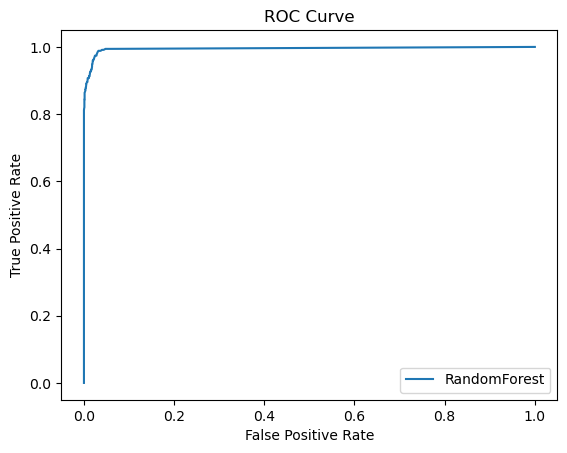

In [45]:
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='RandomForest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Extract feature importances

In [46]:
importances = rf_model.feature_importances_
feature_names = X.columns

In [47]:
# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

In [48]:
# Display feature importance
feature_importance_df

,feature,importance
4,total_logins,0.508055
5,distinct_login_days,0.414014
2,org_id,0.041317
3,invited_by_user_id,0.020882
0,mailing_list,0.003551
6,creation_source_ORG_INVITE,0.003506
1,marketing_drip,0.002882
7,creation_source_PERSONAL_PROJECTS,0.002321
9,creation_source_SIGNUP_GOOGLE_AUTH,0.001827
8,creation_source_SIGNUP,0.001644


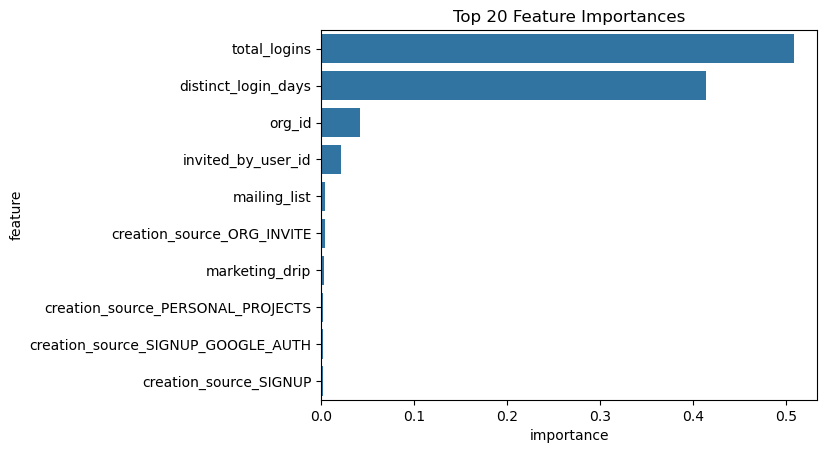

In [49]:
# Plot feature importance

def plot_feat_import():
    sns.barplot(x='importance', y='feature', data=feature_importance_df)
    plt.title('Top 20 Feature Importances')
    plt.show()

plot_feat_import()

In [50]:
#look a little closer at 'invited_by_user_id'

# Filter for adopted users
adopted_users = df_user[df_user['adopted_user'] == 1]

# Group by 'invited_by_user_id' and count the number of adopted users
adopted_counts = adopted_users.groupby('invited_by_user_id').size().reset_index(name='counts')

# Sort the results to see which invited_by_user_id's have the most adopted users
adopted_counts = adopted_counts.sort_values(by='counts', ascending=False)

# Display the result
adopted_counts.head()

,invited_by_user_id,counts
0,0.0,713
692,10628.0,4
135,2354.0,4
668,10163.0,3
633,9510.0,3


In [51]:
#look a little closer at 'invited_by_user_id'

# Filter for adopted users==0
adopted_users_0 = df_user[df_user['adopted_user'] == 0]

# Group by 'invited_by_user_id' and count the number of adopted users
adopted_counts_0 = adopted_users_0.groupby('invited_by_user_id').size().reset_index(name='counts')

# Sort the results to see which invited_by_user_id's have the most adopted users
adopted_counts_0 = adopted_counts_0.sort_values(by='counts', ascending=False)

# Display the result
adopted_counts_0.head()

,invited_by_user_id,counts
0,0.0,4870
2149,10741.0,12
279,1525.0,11
2351,11770.0,10
454,2308.0,10


In [52]:
adopted_users = df_user[df_user['adopted_user'] == 1]

# Group by 'org_id' and count the number of adopted users
adopted_counts_org = adopted_users.groupby('org_id').size().reset_index(name='counts')

# Sort the results to see which org_id's have the most adopted users
adopted_counts_org = adopted_counts_org.sort_values(by='counts', ascending=False)

# Display the result
adopted_counts_org.head()

,org_id,counts
4,4,17
1,1,16
7,7,16
2,2,15
9,9,14


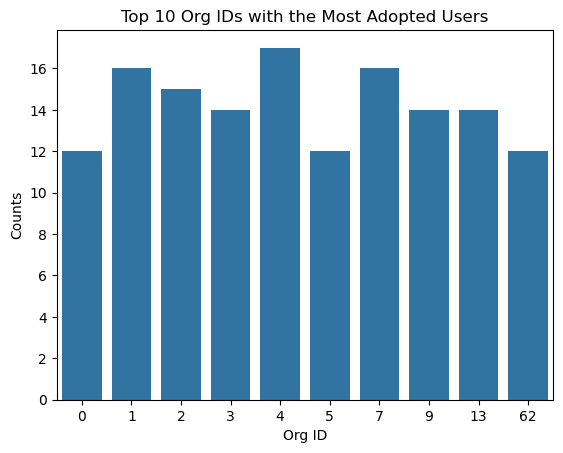

In [53]:
top_org_id = adopted_counts_org.head(10)
sns.barplot(x='org_id', y='counts', data=top_org_id)
plt.title('Top 10 Org IDs with the Most Adopted Users')
plt.xlabel('Org ID')
plt.ylabel('Counts')
plt.show()

# Conclusions

Most Important Features for Determining Future User Adoption:
- Total logins
- Distinct Login Days
- Organization ID

Further work/investigations:

- investigate impact on adoption if being invited at all (True/False rather than knowing indivisuals)
- investigate impact on adoption if being in an org at all (True/False rather than knowing ID's)